**RECOMMENDATION**: retart the notebook for each section

---
---
---
**1.1 EXAMPLE: OPTIMIZATION OF SINGLE MONTH OPERATION FOR SINGLE BESS CONFIGURATION**, hour-level granurality

In [1]:
import numpy as np

from src.utils import *
from src import *
suppress_gurobi_parallel_spam()


Set parameter Username
Set parameter LicenseID to value 2659802
Academic license - for non-commercial use only - expires 2026-05-01


In [2]:
timeseries = Timeseries(
    is_minute=False, # False -> hour-level granurality
    is_historical=True, 
    end_exclude=True, # True -> subtract one hour from given time_end
    time_start=2022090100, 
    time_end=2022100100,
)
    
parameter = Parameter(
    timeseries,
    parameter_pnnl=True, 
    pnnl_year=2023, # 2023 / 2030
    pnnl_technology="Lithium-ion_LFP", # Lithium-ion_LFP / Lithium-ion_NMC / Lead_Acid / Zinc / Vanadium_Redox_Flow
    pnnl_estimate="Point", # Point / Low / High
    pnnl_fxrate=1333, # FX rate (USDKRW) for the given period (used for OpEX & CapEX)
)

In [3]:
print_bess_config(parameter)

 [*CONFIGS FROM PNNL*]
 [**FOR GIVEN SPECS**]
 [zero  MWh   MW   hr]
 [ idx  CAP  PWR  DUR]
[[   0    2    1    2]
 [   1    4    1    4]
 [   2    6    1    6]
 [   3    8    1    8]
 [   4   10    1   10]
 [   5   20   10    2]
 [   6   24    1   24]
 [   7   40   10    4]
 [   8   60   10    6]
 [   9   80   10    8]
 [  10  100    1  100]
 [  11  100   10   10]
 [  12  200  100    2]
 [  13  240   10   24]
 [  14  400  100    4]
 [  15  600  100    6]
 [  16  800  100    8]
 [  17 1000   10  100]
 [  18 1000  100   10]]


In [4]:
# bess idx
idx_config = 12

In [5]:
solver = Solver(
    timeseries,
    parameter,
    do_single=True, # returns model if only single configuration
    idx_config=idx_config,
    do_efficiency=True, # charging and discharging efficiency
    do_rest=True, # rest before charge & rest after charge
)

net_arbitrage_revenue, variables = solver.solve()

In [6]:
print(f"{net_arbitrage_revenue:,.0f} KRW")

275,331,973 KRW


In [7]:
soc, charge, discharge, switch_charge, switch_discharge = [variable.reshape(-1) for variable in np.split(variables, 5)]

---
---
---
**1.2 PLOTING BESS OPERATION SCHEDULING**, based on result of 1.1

In [8]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

In [9]:
soc, charge, discharge = soc / 1000, charge / 1000, discharge / 1000 # k-> M

In [10]:
time_start_plot, time_end_plot, end_exclude = 2022090900, 20220913000, True


time_start_plot, time_end_plot = timeseries.get_datetime64(time_start_plot), timeseries.get_datetime64(time_end_plot, end_exclude)
time_start_plot_idx, time_end_plot_idx = tuple([int(np.where(timeseries.timestamp == time)[0][0]) for time in [time_start_plot, time_end_plot]])

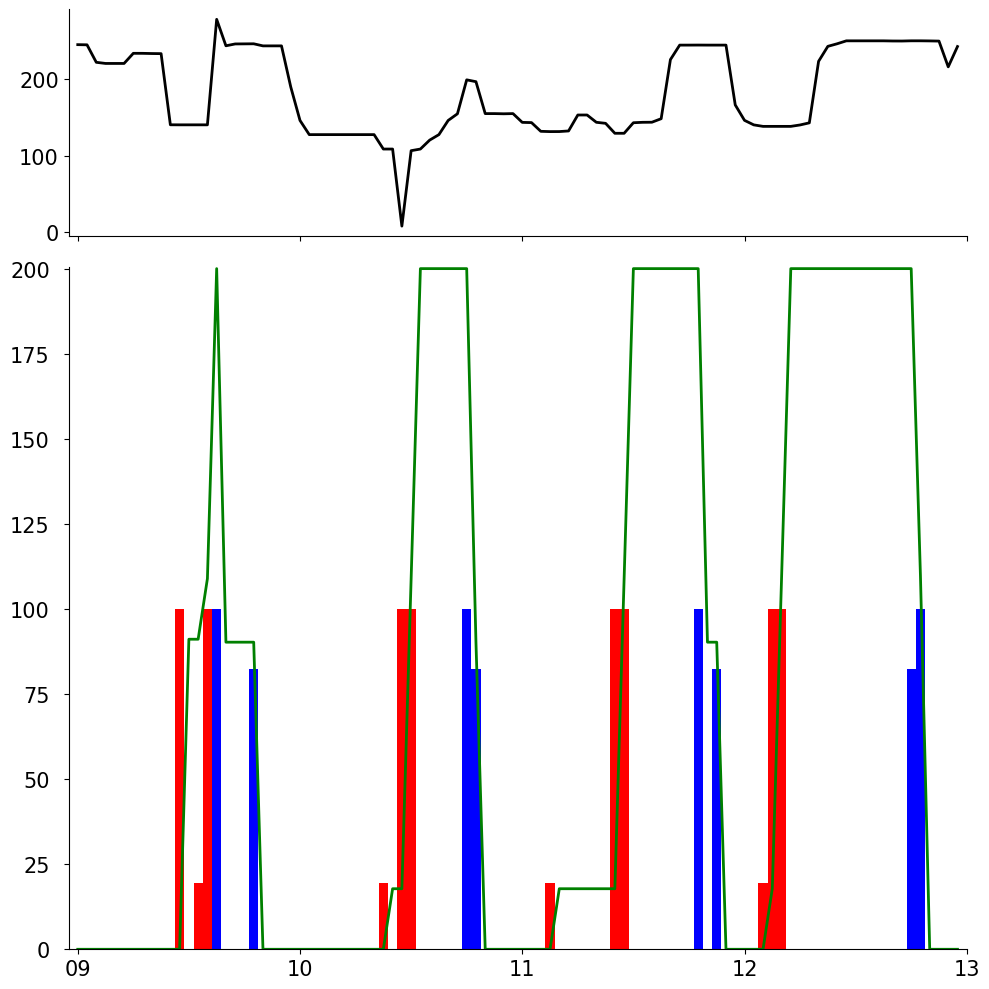

In [11]:
timestamp_plot = timeseries.timestamp[time_start_plot_idx:time_end_plot_idx+1]
smp_plot = timeseries.smp[time_start_plot_idx:time_end_plot_idx+1]
soc_plot = soc[time_start_plot_idx:time_end_plot_idx+1]
charge_plot = charge[time_start_plot_idx:time_end_plot_idx+1]
discharge_plot = discharge[time_start_plot_idx:time_end_plot_idx+1]

fig, axes = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [1, 3]})
ax1, ax2 = axes
ax1.plot(timestamp_plot, smp_plot, color="black", linewidth=2)
ax2.bar(timestamp_plot, charge_plot, color="red", width=np.timedelta64(1, "h"))
ax2.bar(timestamp_plot, discharge_plot, color="blue", width=np.timedelta64(1, "h"))
ax2.plot(timestamp_plot, soc_plot, color="green", linewidth=2)

# LIMIT
ax1.set_xlim(time_start_plot-1, time_end_plot+1)
ax2.set_xlim(time_start_plot-1, time_end_plot+1)
ax2.set_ylim(0, (parameter.capacities[idx_config] / 1000)+0.5)

# X-TICK/LABEL (NEED TO BE CUSTOMIZED FOR EACH DIFFERENT PLOT)
xticklabels_date = np.arange(
    time_start_plot.astype("datetime64[D]"),
    (time_end_plot + end_exclude).astype("datetime64[D]") + 1,
    dtype="datetime64[D]"
).tolist() # desired ticklabels

xticks_float = [date2num(xticklabel_date) for xticklabel_date in xticklabels_date] # xtick (float) manipulation
ax2.set_xticks(xticks_float)

xticklabels_date_md = [xticklabel_date.strftime("%m-%d") for xticklabel_date in xticklabels_date]
ax2.set_xticklabels(xticklabels_date_md) # xticklabel (date) manipulation
# ABOVE DEFAULT, BELOW CUSTOM

xticklabels_date_d = [xticklabel_date.strftime("%d") for xticklabel_date in xticklabels_date]
ax2.set_xticklabels(xticklabels_date_d)

# TICK PARAM DESIGN
ax1.set_xticks(xticks_float) # ax1 tick copying the ax2
ax1.tick_params(axis="x", labelbottom=False)
ax1.tick_params(axis="y", labelsize=15)
ax2.tick_params(axis="y", pad=10)
ax2.tick_params(axis="both", labelsize=15)
# BOX
for spine in ["top", "right"]:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

fig.tight_layout()
plt.show(fig)

---
---
---
**EXAMPLE: OPTIMIZATION OF 12 MONTHS OPERATION FOR SINGLE BESS CONFIGURATION**, hour-level granurality

In [12]:
import numpy as np

from src.utils import *
from src import *
suppress_gurobi_parallel_spam()

In [13]:
# bess idx
idx_config = 12

In [14]:
# 12 months date setting # replaced by bash commands (capitalized)
DATE = np.concatenate((np.arange(0, 120000, 10000) + 2022010100, np.array([2023010100])))
ITERATOR = enumerate(zip(DATE[:-1].tolist(), DATE[1:].tolist()))

In [15]:
TOTAL_NET_ARBITRAGE_REVENUE = 0

for IDX_MONTH, (TIME_START, TIME_END) in ITERATOR:

    timeseries = Timeseries(
        is_minute=False, 
        is_historical=True, 
        end_exclude=True, 
        time_start=TIME_START, 
        time_end=TIME_END,
    )
        
    parameter = Parameter(
        timeseries,
        parameter_pnnl=True, 
        pnnl_year=2023,
        pnnl_technology="Lithium-ion_LFP",
        pnnl_estimate="Point",
        pnnl_fxrate=1333, # advised to keep the rate identical for all months for simpler CapEX calculation
    )

    solver = Solver(
        timeseries,
        parameter,
        do_single=False, # returns model if only single configuration
        idx_config=idx_config,
        do_efficiency=True,
        do_rest=True,
    )

    TOTAL_NET_ARBITRAGE_REVENUE += solver.solve()

In [16]:
print(f"{TOTAL_NET_ARBITRAGE_REVENUE:,.0f} KRW")

1,775,336,819 KRW
